# Memory-efficient SAGA

In [1]:
import pyximport; pyximport.install()
# import saga_authors

import numpy as np
import scipy.sparse as sparse
import sklearn.linear_model, sklearn.metrics
import matplotlib.pyplot as plt
import time

%matplotlib inline

## Data

Problem: Prediction of the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s.

* Dataset can be downloaded at https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD.
* 90 audio attributes: 12 = timbre average, 78 = timbre covariance
    * Features extracted from the 'timbre' features from The Echo Nest API. We take the average and covariance over all 'segments', each segment being described by a 12-dimensional timbre vector.
* The first value is the year (target), ranging from 1922 to 2011. 
* train: first 463,715 examples, test: last 51,630 examples
    * It avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In [2]:
data = np.loadtxt('YearPredictionMSD.txt', delimiter=',')

In [3]:
# Song release year.
train_target = data[:463715,0]  #.astype(np.int32)
test_target  = data[463715:,0]  #.astype(np.int32)
assert test_target.shape == (51630,)

# Audio features.
train_data = data[:463715,1:]
test_data  = data[463715:,1:]
assert train_data.shape == (463715,90)
assert test_data.shape == (51630,90)

# Subset for fast testing purpose.
#n = 10000
#train_data = data[:n,1:]
#train_target = data[:n,0]

# Normalize so as to do not need an intercept.
intercept = train_target.mean()
data_mean = train_data.mean(axis=0)
train_target = train_target - intercept
test_target = test_target - intercept
train_data = train_data - data_mean
test_data = test_data - data_mean

## Linear regression: ground truth

* Sanity check of the performance of a linear classifier.
* Exact least-square solution to compare with SAGA.

In [4]:
def score(x, dataset, plot=None):
    A = eval('{}_data'.format(dataset))
    y = eval('{}_target'.format(dataset)) + intercept
    pred = A.dot(x) + intercept
    score = sklearn.metrics.r2_score(y, pred)
    
    if plot:
        plt.figure(figsize=(17,5))
        plt.plot(pred[:plot], '.', label='predicted')
        plt.plot(y[:plot], '.', label='ground truth')
        plt.title(dataset)
        plt.xlabel('sample')
        plt.ylabel('release year')
        plt.legend()
    
    return score

R^2 score: 0.2375
R^2 score: 0.2320


NameError: name 'n' is not defined

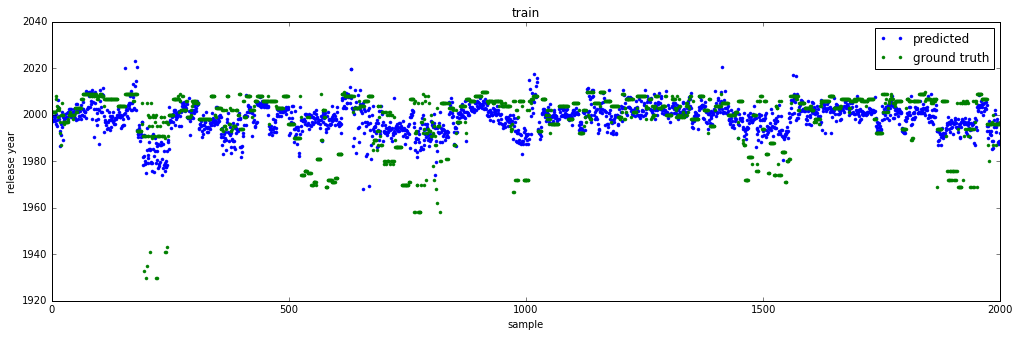

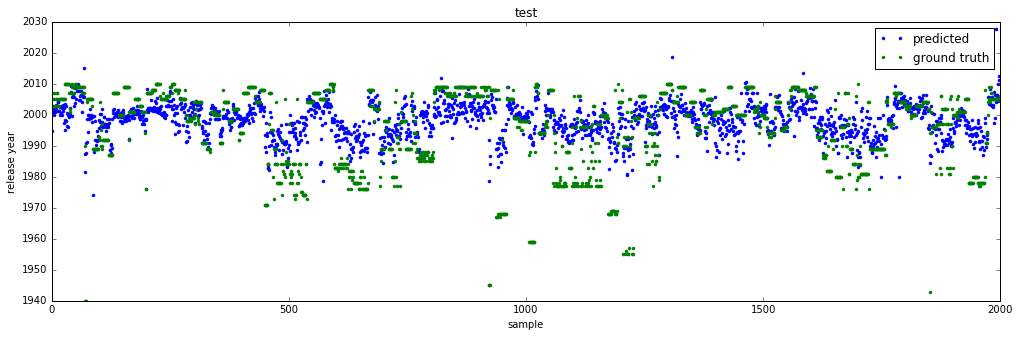

In [5]:
x_natural = np.linalg.lstsq(train_data, train_target)[0]
print('R^2 score: {:.4f}'.format(score(x_natural, 'train', plot=2000)))
print('R^2 score: {:.4f}'.format(score(x_natural, 'test', plot=2000)))

cls = sklearn.linear_model.LinearRegression(fit_intercept=True)
cls.fit(train_data, train_target)
assert cls.intercept_ < 1e-10
np.testing.assert_allclose(cls.coef_, x_natural)

cls = sklearn.linear_model.Ridge(alpha=1e3*n, fit_intercept=True)
cls.fit(train_data, train_target)
print('R^2 score: {:.4f}'.format(score(cls.coef_, 'train')))
print('R^2 score: {:.4f}'.format(score(cls.coef_, 'test', plot=2000)))

cls = sklearn.linear_model.Lasso(alpha=1e0, fit_intercept=True)
cls.fit(train_data, train_target)
print('R^2 score: {:.4f}'.format(score(cls.coef_, 'train')))
print('R^2 score: {:.4f}'.format(score(cls.coef_, 'test', plot=2000)))

## SAGA

Various implementations.

1. Cython code from the authors.
    * To solve least-square problems only.
    * It uses the tricks from Section 4 of the paper.
2. Minimal and straightforward implementation by us.
    * It provides the same results and is only 3 times slower.
3. Mini-batch version.
    1. Mini-batches are picked at random during initialization and stay the same for the whole training.
    1. Mini-batches are picked at random for each epoch.

In [6]:
def saga_lstsq_authors(A, y, maxiter, gamma, reg=0):
    """
    Solve min_x ||Ax - b||_2^2 reg*||x||_2^2
    
    Parameters:
        gamma: step size or learning rate
        reg:   amount of L2 regularization
    """
    # Proper data type.
    A = sparse.csc_matrix(A.T)
    A.indices = A.indices.astype(np.int64)
    A.indptr = A.indptr.astype(np.int64)
    y = y.astype(np.float64)
    
    # Algorithm (eta is the inverse step size).
    props = {'eta': 1 / gamma, 'reg': reg}
    x = saga_authors.saga_lstsq(A, y, maxiter, props)
    return x

In [7]:
def saga(A, y, gradf, prox, maxiter, gamma):
    """Minimal and straightforward implementation of SAGA."""
    n, d = A.shape  # number of observations x dimensionality
    x = np.zeros(d)
    grads = np.array([gradf(A, x, y, i) for i in range(n)])
    avg = grads.mean(axis=0)
    X = np.empty((maxiter, d))
    
    for epoch in range(maxiter):
        #indices = np.random.permutation(n)
        indices = np.random.randint(0, n, n)
        
        for i in indices:
            grad = gradf(A, x, y, i)
            x = x - gamma * (grad - grads[i,:] + avg)
            x = prox(x, gamma)
            avg += (grad - grads[i,:]) / n
            grads[i,:] = grad
            
        X[epoch,:] = x
        
    return X

In [8]:
def saga_mb(A, y, gradf, prox, maxiter, gamma, mb_size=100):
    """
    Mini-batch version of SAGA.
    Mini-batches are chosen at random and fixed for the whole training.
    """
    n, d = A.shape  # number of observations x dimensionality
    n //= mb_size
    x = np.zeros(d)
    X = np.empty((maxiter, d))
    
    batches = np.random.permutation(n*mb_size).reshape((mb_size, -1))
    grads = np.array([gradf(A, x, y, batches[:,i]) for i in range(n)])
    avg = grads.mean(axis=0)
    
    for epoch in range(maxiter):
        
        for i in np.random.randint(0, n, n):
            grad = gradf(A, x, y, batches[:,i])
            x = x - gamma * (grad - grads[i,:] + avg)
            x = prox(x, gamma)
            avg += (grad - grads[i,:]) / n
            grads[i,:] = grad
            
        X[epoch,:] = x
        
    return X

In [9]:
def saga_mb_2(A, y, gradf, prox, maxiter, gamma, mb_size=100):
    """
    Mini-batch version of SAGA.
    Mini-batches are chosen at random for each epoch.
    """
    n, d = A.shape  # number of observations x dimensionality
    n //= mb_size
    x = np.zeros(d)
    X = np.empty((maxiter, d))
    
    for epoch in range(maxiter):
        
        batches = np.random.permutation(n*mb_size).reshape((mb_size, -1))
        grads = np.array([gradf(A, x, y, batches[:,i]) for i in range(n)])
        avg = grads.mean(axis=0)
        
        for i in np.random.randint(0, n, n):
            grad = gradf(A, x, y, batches[:,i])
            x = x - gamma * (grad - grads[i,:] + avg)
            x = prox(x, gamma)
            avg += (grad - grads[i,:]) / n
            grads[i,:] = grad
            
        X[epoch,:] = x
        
    return X

## Synthetic problem

Test the methods and be sure that they work.

In [10]:
def plot_convergence(f, A, y, Xs, x_natural, labels):
    plt.figure(figsize=(17,5))
    objectives = []
    for X, label in zip(Xs, labels):
        maxiter = X.shape[0]
        objective = np.array([f(A, X[i,:], y) for i in range(maxiter)])
        objective -= f(A, x_natural, y)
        objectives.append(objective)
        plt.semilogy(np.arange(maxiter)+1, objective, label=label)
    plt.legend(loc='best')
    plt.title('convergence')
    plt.xlabel('epoch')
    plt.ylabel('function sub-optimality')
    return objectives

Elapsed time: 0.39s
Elapsed time: 0.06s
Elapsed time: 0.11s


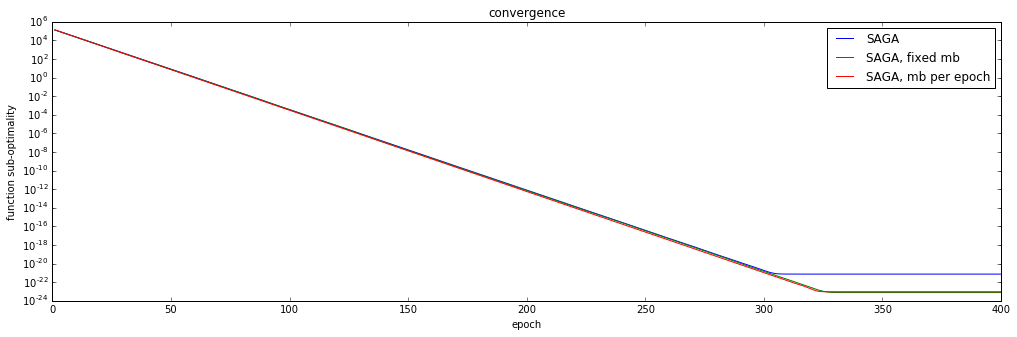

In [11]:
f_no  = lambda A, x, y: np.sum((A.dot(x) - y)**2) / 2
gradf = lambda A, x, y, i: A[i,:].T.dot(A[i,:].dot(x) - y[i])
prox_no = lambda x, gamma: x

n = 100
A = np.identity(n)
y = np.arange(n)

params = {'maxiter': 400, 'gamma': 0.1}

# tstart = time.process_time()
# x = saga_lstsq_authors(A, y, **params)
# print('Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
# np.testing.assert_allclose(x, y)

tstart = time.process_time()
X1 = saga(A, y, gradf, prox_no, **params)
print('Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.testing.assert_allclose(X1[-1,:], y)

tstart = time.process_time()
X2 = saga_mb(A, y, gradf, prox_no, **params, mb_size=10)
print('Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.testing.assert_allclose(X2[-1,:], y)

tstart = time.process_time()
X3 = saga_mb_2(A, y, gradf, prox_no, **params, mb_size=10)
print('Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.testing.assert_allclose(X3[-1,:], y)

plot_convergence(f_no, A, y, [X1, X2, X3], y, ['SAGA', 'SAGA, fixed mb', 'SAGA, mb per epoch']);

## Linear regression: SAGA

Compare our various implementations of SAGA and be sure that they yield the same results.

* They all get the same performance with the same learning rate.
* However, bigger the mini-batch size, smaller the learning rate to avoid divergence.
* At similar running time, the mini-batch method always beats the standard one (in R^2 score and loss).

R^2 score: 0.2126 --> 0.2066 (85.23s)
R^2 score: 0.2242 --> 0.2179 (92.06s)
R^2 score: 0.2242 --> 0.2179 (279.73s)


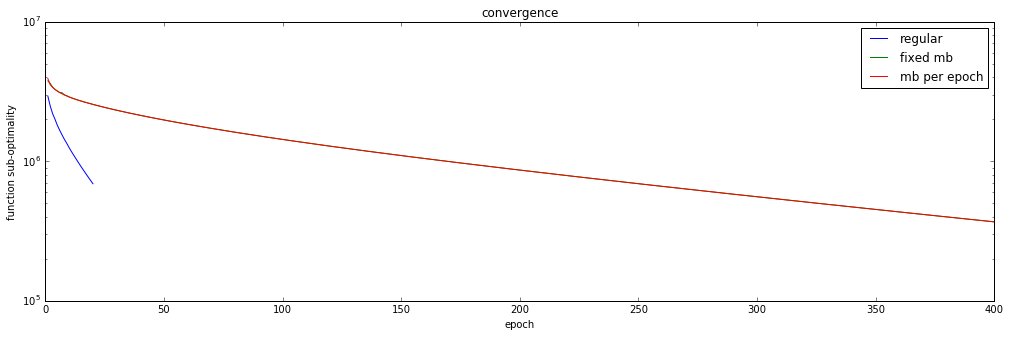

In [12]:
maxiter = 20
maxiter_mb = 400
gamma = 5e-9
gamma_mb = 4e-10 # 2e-9 for 100, 4e-10 for 500
mb_size = 500

# tstart = time.process_time()
# x = saga_lstsq_authors(train_data, train_target, maxiter, gamma)
# print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
#         score(x, 'train'), score(x, 'test'), time.process_time()-tstart))

tstart = time.process_time()
X1 = saga(train_data, train_target, gradf, prox_no, maxiter, gamma)
print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
        score(X1[-1,:], 'train'), score(X1[-1,:], 'test'), time.process_time()-tstart))

tstart = time.process_time()
X2 = saga_mb(train_data, train_target, gradf, prox_no, maxiter_mb, gamma_mb, mb_size)
print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
        score(X2[-1,:], 'train'), score(X2[-1,:], 'test'), time.process_time()-tstart))

tstart = time.process_time()
X3 = saga_mb_2(train_data, train_target, gradf, prox_no, maxiter_mb, gamma_mb, mb_size)
print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
        score(X3[-1,:], 'train'), score(X3[-1,:], 'test'), time.process_time()-tstart))

plot_convergence(f_no, train_data, train_target, [X1, X2, X3], x_natural, ['regular', 'fixed mb', 'mb per epoch']);

In [ ]:
maxiter = 20
gamma = 5e-9

tstart = time.process_time()
X1 = saga(train_data, train_target, gradf, prox_no, maxiter, gamma)
print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
        score(X1[-1,:], 'train'), score(X1[-1,:], 'test'), time.process_time()-tstart))

reg = 1e3
f_l2  = lambda A, x, y: np.sum((A.dot(x) - y)**2) / 2 + reg * np.linalg.norm(x, 2)
prox_l2 = lambda x, gamma: 1 / (1+reg*gamma) * x;

tstart = time.process_time()
X2 = saga(train_data, train_target, gradf, prox_l2, maxiter, gamma)
print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
        score(X2[-1,:], 'train'), score(X2[-1,:], 'test'), time.process_time()-tstart))

reg = 1e0
f_l1  = lambda A, x, y: np.sum((A.dot(x) - y)**2) / 2 + reg * np.linalg.norm(x, 1)
prox_l1 = lambda x, gamma: np.sign(x) * np.maximum(np.abs(x) - gamma*reg, 0)

tstart = time.process_time()
X3 = saga(train_data, train_target, gradf, prox_l1, maxiter, gamma)
print('R^2 score: {:.4f} --> {:.4f} ({:.2f}s)'.format(
        score(X3[-1,:], 'train'), score(X3[-1,:], 'test'), time.process_time()-tstart))

plot_convergence(f_no, train_data, train_target, [X1, X2, X3], x_natural, ['no reg', 'l2 reg', 'l1 reg']);

## Results

Measure different metrics with respect to the mini-batch size.

* Performance: loss and R^2 score.
* Speed: total running time.
* Memory: MB used to store the gradients.

In [ ]:
mb_sizes = [1, 20, 50, 100, 200, 500]
gammas = [4e-9, 3e-9, 3e-9, 1e-9, 1e-9, 4e-10]
maxiters = [12, 170, 314, 440, 540, 380]

Xs, train_scores, test_scores, ptimes = [], [], [], []
for mb_size, gamma, maxiter in zip(mb_sizes, gammas, maxiters):
    tstart = time.process_time()
    X = saga_mb(train_data, train_target, gradf, prox_no, maxiter, gamma, mb_size)
    ptimes.append(time.process_time() - tstart)
    Xs.append(X)
    train_scores.append(score(X[-1,:], 'train'))
    test_scores.append(score(X[-1,:], 'test'))
    print('size {:4d} in {:.2f}s'.format(mb_size, ptimes[-1]))

labels = ['mini-batch size = {}'.format(mb_size) for mb_size in mb_sizes]
objectives = plot_convergence(f_no, train_data, train_target, Xs, x_natural, labels)

plt.figure(figsize=(17,5))
for maxiter, label, ptime, objective in zip(maxiters, labels, ptimes, objectives):
    tepoch = np.linspace(0, ptime, maxiter)
    plt.semilogy(tepoch, objective, '-', label=label)
plt.legend(loc='best')
plt.xlim(0, min(ptimes))
plt.title('Performance')
plt.xlabel('time [s]')
plt.ylabel('loss')
plt.savefig('img/performance.pdf')

plt.figure(figsize=(17,5))
plt.plot(mb_sizes, train_scores, '.-', label='training set')
plt.plot(mb_sizes, test_scores, '.-', label='testing set')
plt.legend(loc='best')
plt.title('Performance')
plt.xlabel('mini-batch size')
plt.ylabel('R^2 score')
plt.savefig('img/r2_score.pdf')

plt.figure(figsize=(17,5))
plt.plot(mb_sizes, ptimes, '.-')
plt.title('Processing time')
plt.xlabel('mini-batch size')
plt.ylabel('time [s]')

plt.figure(figsize=(17,5))
memory = 8 * train_data.size / np.array(mb_sizes) / 1024**2
plt.semilogy(mb_sizes, memory, '.-')
plt.title('Memory to store gradients')
plt.xlabel('mini-batch size')
plt.ylabel('working memory [MB]');
plt.savefig('img/memory.pdf')